### Loading In The Dataset

In [12]:
import tensorflow as tf 
import matplotlib as plt
import numpy as np
import matplotlib.image as mpimg
from LOAD_DATA import get_IDs, get_image_data

#Train Images
tsv_p_train= "DATA/stimulus_perceptionNaturalImageTraining.tsv"
Path_to_train="DATA/Images_InTrainSet/"
Train_CLASS_ID, Train_IMAGE_ID = get_IDs(tsv_p_train)    
Train_images= get_image_data(Path_to_train, Train_IMAGE_ID, dim=(32,32))
print(Train_images.shape)


#Test Images
tsv_p_test= "DATA/stimulus_perceptionNaturalImageTest.tsv"
Path_to_test= "DATA/Images_InTestSet/"
Test_CLASS_ID, Test_IMAGE_ID = get_IDs(tsv_p_test)    
Test_images= get_image_data(Path_to_test, Test_IMAGE_ID, dim=(32,32))
print(Test_images.shape)

#load fMRI embeddings
fMRIembedding_Train = np.load('DATA/fMRI512embeddingsTrain.npy')
fMRIembedding_Test  = np.load("DATA/fMRI512embeddingsTest.npy")

(1200, 32, 32, 3)
(50, 32, 32, 3)


In [13]:
def Image_Process_Train(x):
    out=x
    for io in range(4):
        out=tf.concat([out, x], axis=0)
    out=out/255
    return out 

def Image_Process_Test(x):
    out=x
    for io in range(23):
        out=tf.concat([out, x], axis=0)

    out=out/255
    return out    

X0=Image_Process_Train(Train_images)
X1=Image_Process_Test(Test_images)


L0 = fMRIembedding_Train *100
L1 = fMRIembedding_Test  *100



In [14]:
from MODEL import CVAE


latent_dim=2
model1 = CVAE( 
    
    encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding='same'), #input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),               
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
        
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim, )
            ], name='encoder'

        ),
    decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=8*8*32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
                
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                #tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same' , activation = 'sigmoid'),
            ],
             name='encoder'
        ),


   latent_dim = latent_dim
    
)

model1((X0[:5], L0[:5]))
model1.summary()
model1.encoder.summary()
model1.decoder.summary()


Model: "cvae_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (5, 4)                    380100    
                                                                 
 encoder (Sequential)        (5, 32, 32, 3)            2389507   
                                                                 
Total params: 2,769,611
Trainable params: 2,769,607
Non-trainable params: 4
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (5, 16, 16, 256)          7168      
                                                                 
 conv2d_4 (Conv2D)           (5, 8, 8, 128)            295040    
                                                                 
 conv2d_5 (Conv2D)           (5, 

In [15]:
def kld_loss(z_log_var, z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(kl_loss, axis=1)
    return kl_loss

def rec_loss(data, recon):
    recon_loss = tf.keras.losses.mean_squared_error(data, recon)
    recon_loss = tf.reduce_sum(recon_loss, axis=(1,2))
    return recon_loss



model1.compile( optimizer = tf.keras.optimizers.Adam(1), **{'kld_loss':kld_loss, 'rec_loss':rec_loss} )  


model1.fit(
    (X0, L0), X0,
    epochs     = 50,
    batch_size = 1000
    )


Epoch 1/50
6/6 [==============================] - 20s 2s/step - kld_loss: 0.1059 - recon_loss: 239.5030
Epoch 2/50
6/6 [==============================] - 9s 2s/step - kld_loss: 2.7557e-04 - recon_loss: 151.2330
Epoch 3/50
6/6 [==============================] - 9s 2s/step - kld_loss: 6.5035e-05 - recon_loss: 112.4295
Epoch 4/50
6/6 [==============================] - 9s 2s/step - kld_loss: 6.4079e-05 - recon_loss: 101.9048
Epoch 5/50
6/6 [==============================] - 9s 2s/step - kld_loss: 7.3138e-05 - recon_loss: 108.6880
Epoch 6/50
6/6 [==============================] - 9s 2s/step - kld_loss: 6.4019e-05 - recon_loss: 96.0991
Epoch 7/50
6/6 [==============================] - 9s 2s/step - kld_loss: 7.8485e-05 - recon_loss: 96.3556
Epoch 8/50
6/6 [==============================] - 9s 2s/step - kld_loss: 6.2445e-05 - recon_loss: 94.1230
Epoch 9/50
6/6 [==============================] - 9s 2s/step - kld_loss: 5.3669e-05 - recon_loss: 91.2899
Epoch 10/50
6/6 [===========================

In [20]:
# model.save_weights('Model1/Checkpoint1')
# load_status = model.load_weights("Model1/Checkpoint1")
# load_status.assert_consumed()


model1.fit(
    (X0, L0), X0,
    epochs     = 200,
    batch_size = 1000
    )




Epoch 1/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.3485 - recon_loss: 60.0099
Epoch 2/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.7087 - recon_loss: 57.8483
Epoch 3/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.3546 - recon_loss: 61.2035
Epoch 4/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.3188 - recon_loss: 59.1146
Epoch 5/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.4779 - recon_loss: 60.0109
Epoch 6/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.4244 - recon_loss: 59.6136
Epoch 7/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.4938 - recon_loss: 57.4413
Epoch 8/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.4560 - recon_loss: 57.6949
Epoch 9/200
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2353 - recon_loss: 55.1526
Epoch 10/200
6/6 [==============================] - 9s 2s/step - kld_loss

In [23]:

model1.fit(
    
    (X0, L0), X0,
    epochs     = 200,
    batch_size = 1000
    )



Epoch 1/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6519 - recon_loss: 38.9741
Epoch 2/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.8126 - recon_loss: 39.5717
Epoch 3/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.8449 - recon_loss: 41.2604
Epoch 4/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.8112 - recon_loss: 40.1424
Epoch 5/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.8432 - recon_loss: 39.9721
Epoch 6/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.8243 - recon_loss: 39.0933
Epoch 7/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.7424 - recon_loss: 41.3714
Epoch 8/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.7882 - recon_loss: 38.3680
Epoch 9/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.7910 - recon_loss: 38.9231
Epoch 10/200
6/6 [==============================] - 9s 2s/step - kld_loss

In [26]:

model1.fit(
    
    (X0, L0), X0,
    epochs     = 200,
    batch_size = 1000
    )


Epoch 1/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.7095 - recon_loss: 33.7893
Epoch 2/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6464 - recon_loss: 34.1227
Epoch 3/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6726 - recon_loss: 33.3692
Epoch 4/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6959 - recon_loss: 33.7212
Epoch 5/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6340 - recon_loss: 33.2823
Epoch 6/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6584 - recon_loss: 33.2889
Epoch 7/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.7230 - recon_loss: 33.8159
Epoch 8/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6899 - recon_loss: 34.6320
Epoch 9/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5839 - recon_loss: 33.4916
Epoch 10/200
6/6 [==============================] - 9s 2s/step - kld_loss

In [39]:

model1.fit( 
    (X0, L0), X0,
    epochs     = 200,
    batch_size = 1000,
    )


Epoch 1/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5980 - recon_loss: 30.2261
Epoch 2/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6043 - recon_loss: 31.0792
Epoch 3/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6264 - recon_loss: 30.6657
Epoch 4/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5748 - recon_loss: 29.7972
Epoch 5/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6226 - recon_loss: 30.5261
Epoch 6/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6098 - recon_loss: 29.6838
Epoch 7/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6005 - recon_loss: 31.1529
Epoch 8/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5819 - recon_loss: 30.0391
Epoch 9/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6064 - recon_loss: 30.3377
Epoch 10/200
6/6 [==============================] - 9s 2s/step - kld_loss

In [61]:
model1.fit(
    
    (X0, L0), X0,
    epochs     = 200,
    batch_size = 1000,
    )

Epoch 1/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6603 - recon_loss: 29.3500
Epoch 2/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5654 - recon_loss: 27.3931
Epoch 3/200
6/6 [==============================] - 10s 2s/step - kld_loss: 1.5826 - recon_loss: 27.4575
Epoch 4/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5771 - recon_loss: 28.6964
Epoch 5/200
6/6 [==============================] - 10s 2s/step - kld_loss: 1.5720 - recon_loss: 26.8352
Epoch 6/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5842 - recon_loss: 27.3772
Epoch 7/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6030 - recon_loss: 28.3931
Epoch 8/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.6112 - recon_loss: 27.8772
Epoch 9/200
6/6 [==============================] - 9s 2s/step - kld_loss: 1.5599 - recon_loss: 27.3898
Epoch 10/200
6/6 [==============================] - 9s 2s/step - kld_lo

In [ ]:
model1.compile( optimizer = tf.keras.optimizers.Adam(0.1), **{'kld_loss':kld_loss, 'rec_loss':rec_loss} )  


model1.fit((X0, L0), X0, epochs = 50, batch_size = 1000)

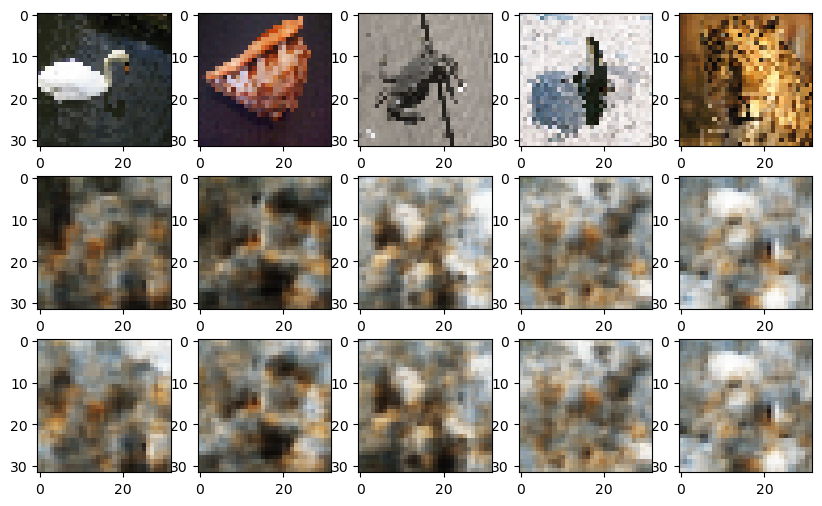

In [76]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

STT=4


ESS=STT+5
x  = X1[STT:ESS]
L_C= L1[STT:ESS]

xp=model1.encoder(x)
m, v, zp = model1.latent_ops(xp)
z_cat = tf.concat([zp, L_C], axis=-1)
z_noise_cat= tf.concat([np.random.uniform( size=( 5,latent_dim)), L_C], axis=-1)

y = model1.decoder(z_cat)
y_noise = model1.decoder(z_noise_cat)



for i in range(5):
    axs[0][i].imshow(x[i,:,:,:])
    axs[1][i].imshow(y[i,:,:,:])
    axs[2][i].imshow(y_noise[i,:,:,:])
